In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

from cnaster_rs import CnasterGraph
from cnaster_rs import (
    get_triangular_lattice,
    get_slices_triangular_lattice_edges,
    nearest_neighbor_edges,
)
from cnaster.field import planar_power_law_fields
from cnaster.plotting import plot_cnaster_graph
from cnaster.ellipse import Ellipse

In [3]:
ground_sites = get_triangular_lattice(70, 70, 0.0)
first_sites = get_triangular_lattice(70, 70, 2.5, x0=(-15, 0))

sites = np.vstack([ground_sites, first_sites])
sites[:10, :]

array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.],
       [5., 0., 0.],
       [6., 0., 0.],
       [7., 0., 0.],
       [8., 0., 0.],
       [9., 0., 0.]])

In [4]:
nxys = np.array([[25, 25], [50, 50]], dtype=np.uint64)

edges = get_slices_triangular_lattice_edges([ground_sites, first_sites], nxys)
edges

array([[   0,    1],
       [   0,   25],
       [   1,    2],
       ...,
       [7398, 7349],
       [7399, 7398],
       [7399, 7349]], dtype=uint64)

In [5]:
alignment_edges, alignment_weights = nearest_neighbor_edges(
    [ground_sites, first_sites], 4, max_distance=5.0
)
alignment_edges

array([[   0, 4915],
       [   0, 4914],
       [   0, 4916],
       ...,
       [9799, 4814],
       [9799, 4815],
       [9799, 4883]], dtype=uint64)

In [6]:
# NB read and snp-read coverages (per spot?)
coverages = np.ones((len(sites), 2))

In [7]:
max_label = 2

graph = CnasterGraph(sites, coverages, max_label)
graph.update_adjacency_list(edges)
graph.update_adjacency_list(alignment_edges, alignment_weights)

graph

CnasterGraph(num_nodes=9800, num_edges=51180, max_label=2, mean_coverage=[1.0, 1.0])

In [8]:
graph.max_edge_weight

4.716990566028302

In [9]:
graph.labels

array([2, 2, 2, ..., 2, 0, 0], dtype=int32)

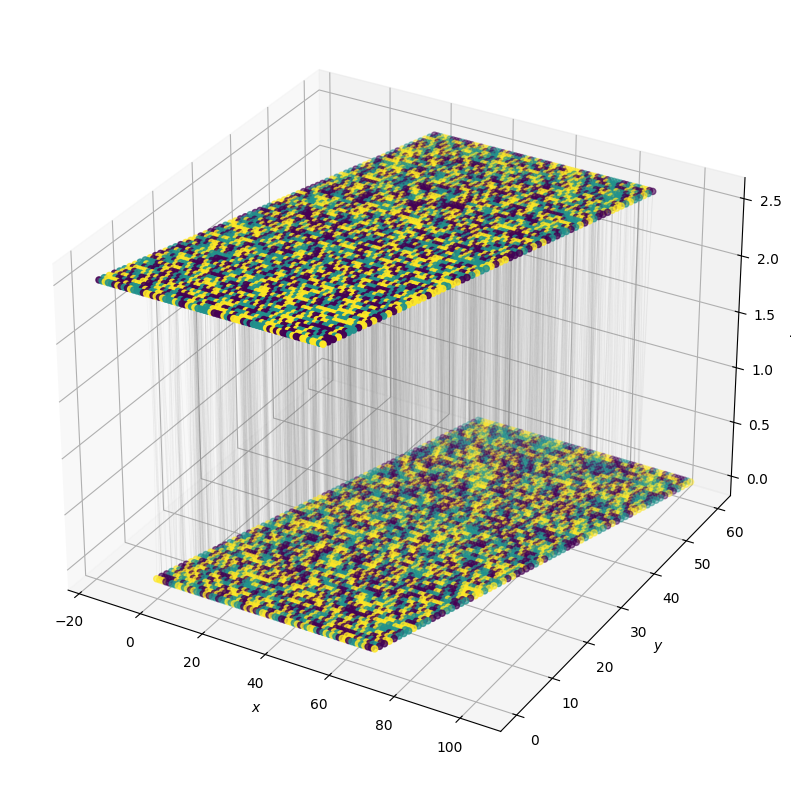

In [10]:
plot_cnaster_graph(graph, edge_downsampling=0.1)

/Users/mw9568/repos/cnaster/python/cnaster/field.py:8: RuntimeWarning: invalid value encountered in power
  field = (scalars - scale * exponent) ** exponent


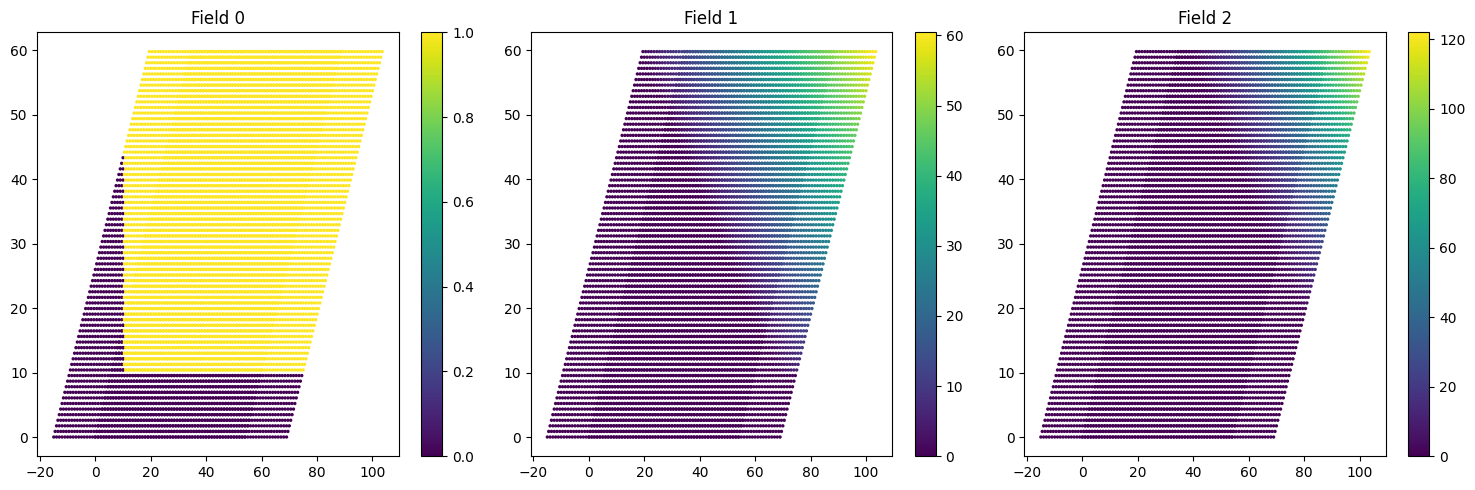

In [11]:
vec_k = np.array([1.0, 1.0, 0.0])
positions = graph.positions

H = planar_power_law_fields(
    positions,
    graph.max_label,
    vec_k,
    scale=55.0,
)

num_fields = H.shape[1]
fig, axes = pl.subplots(1, num_fields, figsize=(5 * num_fields, 5), squeeze=False)

for i in range(num_fields):
    ax = axes[0, i]
    sc = ax.scatter(positions[:, 0], positions[:, 1], c=H[:, i], s=2)

    ax.set_title(f"Field {i}")

    fig.colorbar(sc, ax=ax)

pl.tight_layout()
pl.show()

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/var/folders/15/7gbpxlls5gjdc4w7hm4j0nhw0000gn/T/ipykernel_81734/3346972110.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.scatter(projected, H[:, i], s=1, alpha=0.5, label=f'$\ln H_{i}$')


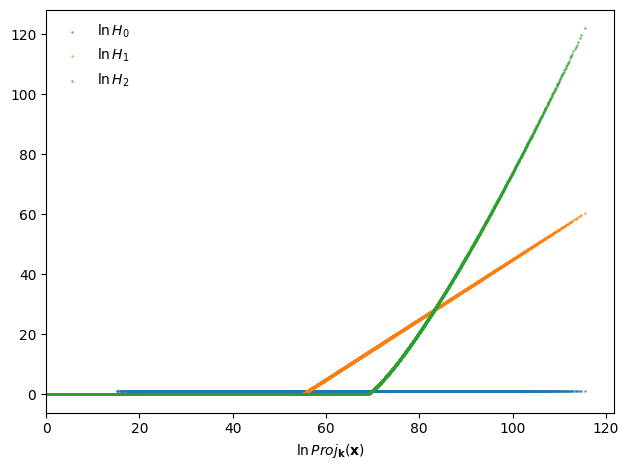

In [12]:
projected = np.dot(positions, vec_k) / np.linalg.norm(vec_k)

for i in range(H.shape[1]):
    plt.scatter(projected, H[:, i], s=1, alpha=0.5, label=f"$\ln H_{i}$")

pl.xlim(0.0, None)

plt.xlabel(r"$\ln Proj_{\mathbf{k}}(\mathbf{x})$")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [13]:
cost, hcost = graph.potts_energy(10.0), graph.potts_energy(1.0, H)
cost, hcost

(478438.6660730393, -11923.738238527229)

In [14]:
graph.reset_node_labels()

In [15]:
graph.icm_learn(0.05, 25, 5.0e-3 * H)

-56.815969044530405

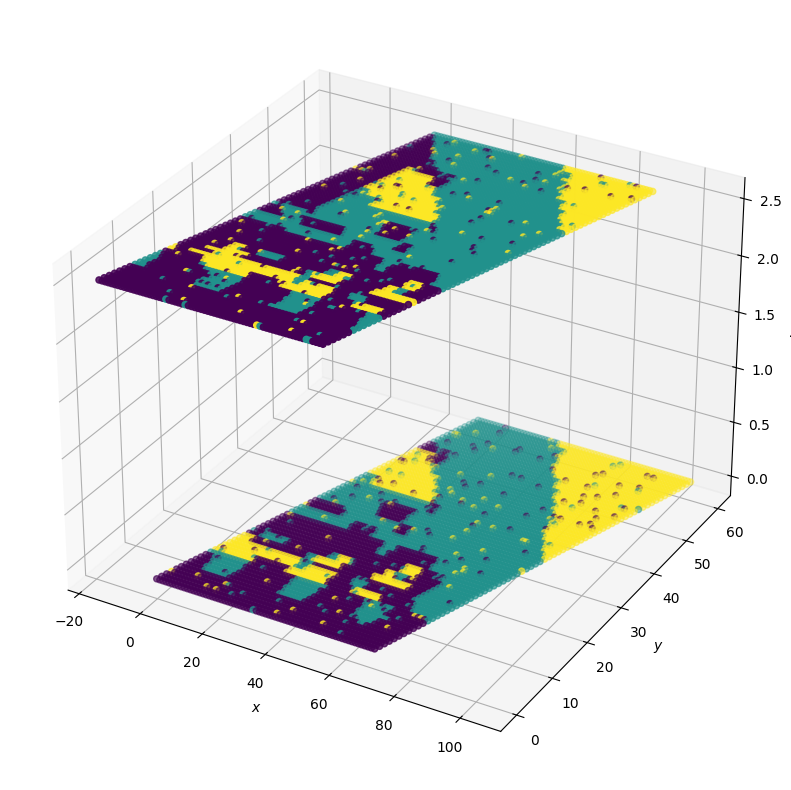

In [16]:
plot_cnaster_graph(graph, add_edges=False)

In [111]:
N = 250
xmin = ymin = -3.0
xmax = ymax = 3.0

x = np.linspace(xmin, xmax, N)
y = np.linspace(ymin, ymax, N)

xg, yg = np.meshgrid(x, y)

pos = np.column_stack([xg.ravel(), yg.ravel()])
pos

array([[-3.        , -3.        ],
       [-2.97590361, -3.        ],
       [-2.95180723, -3.        ],
       ...,
       [ 2.95180723,  3.        ],
       [ 2.97590361,  3.        ],
       [ 3.        ,  3.        ]])

In [112]:
center = np.array([1.0, 0.0])
inv_diag = np.array([1.0, 2.0])

ellipse = Ellipse.from_diagonal(center, inv_diag)
ellipse = ellipse.rotate(np.pi / 4.0)

hierarchy = []

for ii in range(3):
    ellipse = ellipse.get_daughter(0.75)

    hierarchy.append(ellipse)

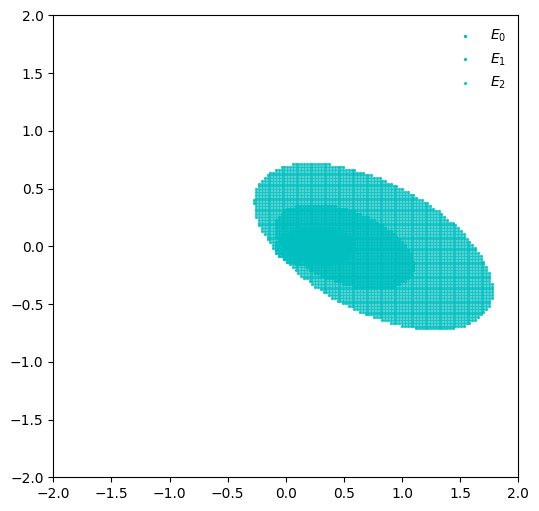

In [118]:
pl.figure(figsize=(6, 6))

for ii, el in enumerate(hierarchy[::-1]):
    isin = np.array([el.contains(xy) for xy in pos])
    pl.scatter(
        pos[isin, 0], pos[isin, 1], s=2, label=f"$E_{ii}$", c="c", alpha=1.0 - 0.1 * ii
    )

pl.xlim([-2.0, 2.0])
pl.ylim([-2.0, 2.0])

pl.legend(frameon=False)

pl.show()

# Done.